# Analysis of the dictionary content used for training
The dictionary file is formatted as follows:

misspelled_word1, ..., misspelled_wordn = correct_word

e.g.

```memorie, momory, mermory, merory => memory```

In [1]:
import itertools
from collections import Counter
import statistics
import sys
import os
sys.path.append(os.path.join('..','src'))

import numpy as np
import pandas as pd
from pytextdist.edit_distance import levenshtein_distance
from google.cloud import bigquery

import utils
import config
from text_cleaner import TextCleaner

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'pytextdist'

In [2]:
client = bigquery.Client(project=config.GCP_PROJECT)
textCleaner = TextCleaner()

In [3]:
# Downloading the data from respected G bucket
bucket_name_source = 'search-external-files-mr'
cloud_file = 'corrections/de_corrections.txt'
dest_file = 'de_corrections_mlsc.txt'
processed_file = 'training_words_3to25_de_to_en_dup.txt'

In [4]:
utils.download_raw_data(bucket_name_source,
    cloud_file,
    dest_file=dest_file,
    project=config.GCP_PROJECT)
with open(dest_file) as file_:  
    content = [line.strip() for line in file_.readlines()]

In [5]:
content[:5]

['aadpter => adapter',
 'aafi, anafri, nafi, anaffi, anfafi => anafi',
 'aagitt, magitta => sagitta',
 'aalysator, analyzator, anlysator, analysato, analisator, analizator, anaysator, anasylator => analysator',
 'aandrijtas => aandrijfas']

In [6]:
import str_utils

def qa_generator(data_line):
    """
    Filter out the data lines from the training dictionary to contain only 
    samples that are 3 edit distances away from each other
    Args:
        data_line (str): raw data single line from training dictionary
    """
    QandA_pair=list()
    questions, answers = data_line.split(" => ")
    question_elements = [question.strip() for question in questions.split(',')]

    replacement_dict = {'Ã¼': 'ue', 'Ã¤': 'ae', 'Ã¶': 'oe', 'ÃŸ': 'ss'}
    answers = str_utils.replace_special_chars(answers, replacement_dict)

    for q_elements in question_elements:
        q_elements = str_utils.replace_special_chars(q_elements, replacement_dict)
        edit_distance = levenshtein_distance(q_elements,answers)
        qa_edit_distance = (q_elements, answers, edit_distance)
        QandA_pair.append(qa_edit_distance)
    return QandA_pair

In [7]:
# Map the generated distances with de-correction.txt - pairs of wrong and right word with the distance
%time
qa_pairs_ed = list(map(qa_generator, content))
len(qa_pairs_ed)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


78555

In [8]:
qa_pairs_ed[:3]

[[('aadpter', 'adapter', 2)],
 [('aafi', 'anafi', 1),
  ('anafri', 'anafi', 1),
  ('nafi', 'anafi', 1),
  ('anaffi', 'anafi', 1),
  ('anfafi', 'anafi', 1)],
 [('aagitt', 'sagitta', 2), ('magitta', 'sagitta', 1)]]

In [9]:
# Flattening the whole list to a list of tuples
qa_pairs_ed = list(itertools.chain.from_iterable(qa_pairs_ed))
# extract the ech element at position_x in the tuples within dedicated list
misspelled_terms, correct_terms, ed_values = zip(*qa_pairs_ed)

In [10]:
repeated_terms = set(misspelled_terms).intersection(correct_terms)
nb_repeated = len(repeated_terms)
print(f"Number of terms existing in correct words and misspelled words:\
 {nb_repeated} ({round(100 * nb_repeated/len(correct_terms), 2)}%)")
list(repeated_terms)[:10]

Number of terms existing in correct words and misspelled words: 1933 (0.61%)


['digitaliser',
 'saugpumpe',
 'schrump',
 'erdleitung',
 'emstb',
 'schrumpfschlau',
 'fritt',
 'shrimp',
 'alutsprecher',
 'klinckenstecker']

# Average length of words in the German dictionary

## Average length of the correct words

In [11]:
total_avg = round(sum( map(len, correct_terms) ) / len(correct_terms), 2)
total_avg

10.34

## Median length of the misspelled words

In [12]:
median_len = statistics.median(map(len, misspelled_terms))
median_len

10

In [13]:
counts_per_edvalue = Counter(ed_values)
nb_words = len(ed_values)
ls = [(edistance, round(counts_per_edvalue[edistance] / nb_words * 100.0, 3)) 
    for edistance, count in counts_per_edvalue.most_common()
]
counts_per_edvalue = sorted(ls, key=lambda t:t[1], reverse=True)
counts_per_edvalue

[(1, 52.602),
 (2, 37.367),
 (3, 7.37),
 (4, 2.159),
 (5, 0.369),
 (6, 0.082),
 (0, 0.033),
 (7, 0.011),
 (8, 0.002),
 (9, 0.002),
 (10, 0.001),
 (13, 0.001),
 (18, 0.001),
 (12, 0.0),
 (14, 0.0),
 (17, 0.0)]

# Distribution of edit distance in DE correction.txt

Text(0, 0.5, '% words in dictionary')

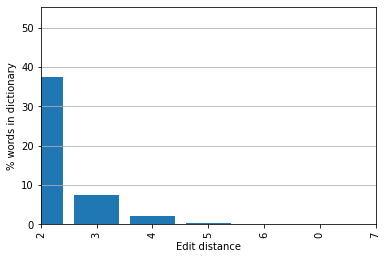

In [14]:
# counts_per_edvalue = Counter(ed_values)
df = pd.DataFrame.from_dict(dict(counts_per_edvalue), orient='index')
ax = df.plot(kind='bar', figsize=(6, 4), stacked=True, width=0.8, legend=None)
ax.set_xlim(1, 7)
ax.set_xlabel('Edit distance')
ax.yaxis.grid()
ax.set_ylabel('% words in dictionary')

In [15]:
# General info about the dataframe
df_describe = pd.DataFrame(np.array(ed_values))
df_describe.describe().T

,count,mean,std,min,25%,50%,75%,max
0,316965.0,1.605663,0.76607,0.0,1.0,1.0,2.0,18.0
